In [15]:
from __future__ import division, print_function

from collections import defaultdict
import csv
from itertools import izip
import random
from xgboost import XGBRegressor

from sklearn import naive_bayes
from sklearn.ensemble.forest import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.tree.tree import DecisionTreeRegressor
from sklearn.linear_model.ridge import Ridge
import sklearn.metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.regression import KNeighborsRegressor
from sklearn import cross_validation
from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

#Set the seed
random.seed(42)

ECOLOGICAL_INDEX = "var14" # we do not use this as it is counterproductive

In [16]:
def get_useful_indexes(header):
    return [
        header.index(feature)
        for feature in header
        if feature not in ["id", "energie_veh", "codepostal", "profession", "var6", "var8", "var14", "prime_tot_ttc"]
    ]

In [17]:
df=pd.read_csv('./data/ech_apprentissage.csv',";")
df.head()

,id,annee_naissance,annee_permis,marque,puis_fiscale,anc_veh,codepostal,energie_veh,kmage_annuel,crm,...,var14,var15,var16,var17,var18,var19,var20,var21,var22,prime_tot_ttc
0,1,1986.0,2006.0,RENAULT,4,1,1034,gpl,2924,68,...,N,1,1,1,27,0,0,0,1,254.75
1,2,1986.0,2006.0,RENAULT,8,2,1034,gpl,11580,50,...,N,2,1,1,28,0,0,0,1,259.89
2,3,1982.0,2001.0,RENAULT,7,2,1034,gpl,7149,95,...,N,3,1,1,29,0,0,0,1,431.65
3,4,1987.0,2006.0,DACIA,5,2,1034,gpl,6526,100,...,N,3,1,1,29,0,0,0,1,577.99
4,5,1994.0,2013.0,CITROEN,4,2,1034,gpl,2872,50,...,N,2,1,4,26,0,1,1,4,222.67


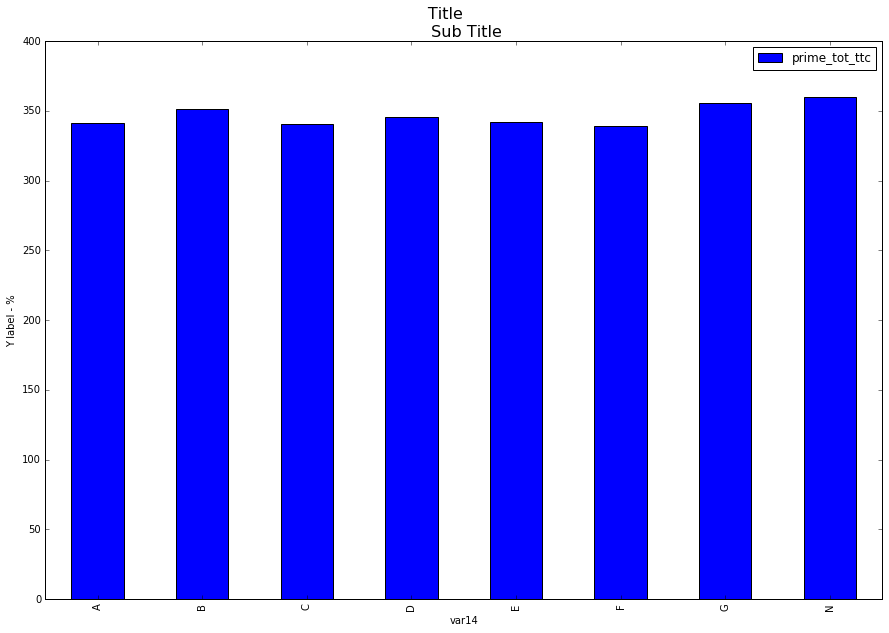

In [18]:
df["prime_tot_ttc"].describe()
df_groupby=df[["var14","prime_tot_ttc"]].groupby("var14").mean()
ax=df_groupby.plot(kind="bar")
fig = matplotlib.pyplot.gcf()
ax.set_title('       Title \
             \n Sub Title',fontsize=16)
ax.set_ylabel('Y label - %')
fig.set_size_inches(15.0, 10.0)

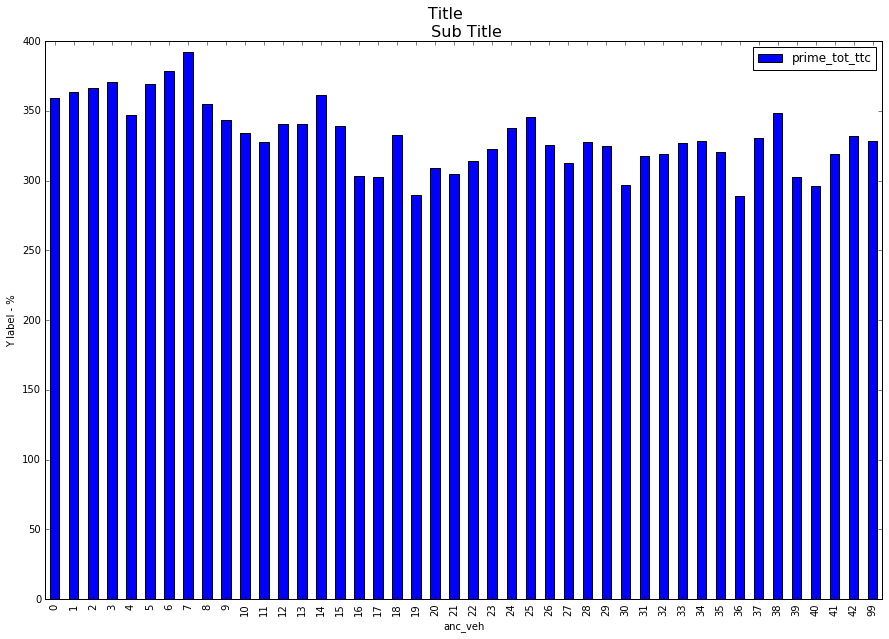

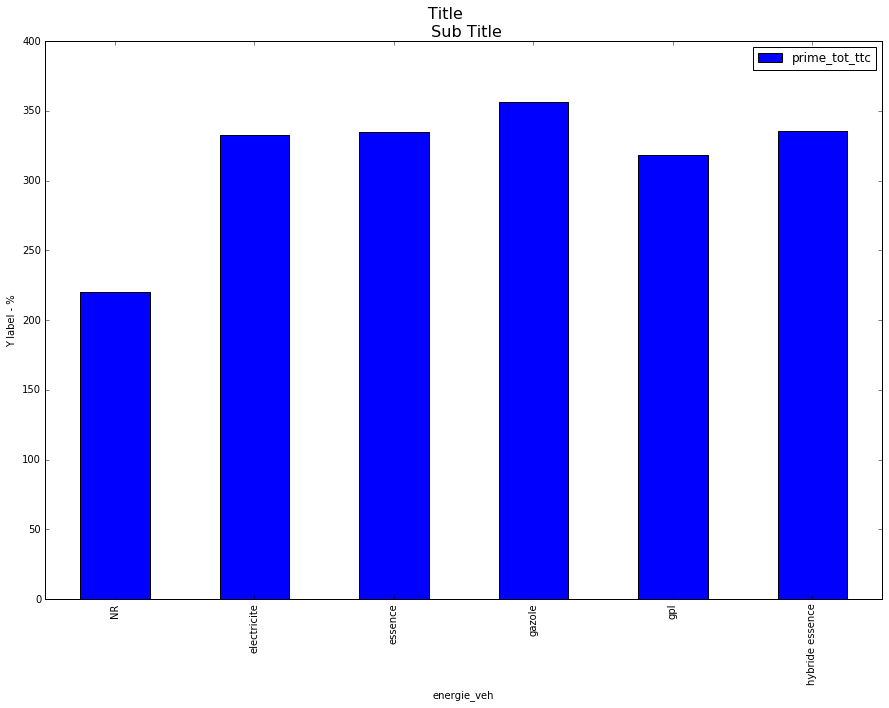

In [19]:
df["prime_tot_ttc"].describe()
df_groupby=df[["anc_veh","prime_tot_ttc"]].groupby("anc_veh").mean()
ax=df_groupby.plot(kind="bar")
fig = matplotlib.pyplot.gcf()
ax.set_title('       Title \
             \n Sub Title',fontsize=16)
ax.set_ylabel('Y label - %')
fig.set_size_inches(15.0, 10.0)

#######################################################################################################

df["prime_tot_ttc"].describe()
df_groupby=df[["energie_veh","prime_tot_ttc"]].groupby("energie_veh").mean()
ax=df_groupby.plot(kind="bar")
fig = matplotlib.pyplot.gcf()
ax.set_title('       Title \
             \n Sub Title',fontsize=16)
ax.set_ylabel('Y label - %')
fig.set_size_inches(15.0, 10.0)

In [20]:
# Open the file
filepath_train="./data/ech_apprentissage.csv"

with open(filepath_train) as file_open:
    # Open the csv reader over the file
    csv_reader=csv.reader(file_open,delimiter=";")
    # Read the first line which is the header
    header=csv_reader.next()
    # Load the dataset contained in the file
    dataset=[[value if value not in ["NR",""] else -1 for value in row] for row in csv_reader]

In [21]:
# compute replacement value for marque
total_sum = 0
sums = defaultdict(lambda: 0)
occurrences = defaultdict(lambda: 0)
marque_index = header.index("marque")
ecological_index = header.index("var14")
prime_index = header.index("prime_tot_ttc")

for entry in dataset:
    sums[entry[marque_index]] += float(entry[prime_index])
    occurrences[entry[marque_index]] += 1
    total_sum += float(entry[prime_index])

means = defaultdict(lambda: total_sum / len(dataset), {entry: sums[entry] / occurrences[entry] for entry in sums.keys()})

for entry in dataset:
    entry[marque_index] = means[entry[marque_index]]

In [22]:
# Filter the dataset based on the column name
indexes_to_filter = get_useful_indexes(header)
dataset_filtered=[[float(row[index]) for index in indexes_to_filter] for row in dataset]

# Build the structure containing the target
targets=[float(row[header.index("prime_tot_ttc")]) for row in dataset]

In [23]:
#Split the datasets to have one for learning and the other for the test
train_dataset=[]
test_dataset=[]
train_target=[]
test_target=[]

for row,target in zip(dataset_filtered,targets):
    if random.random() < 0.70:
        train_dataset.append(row)
        train_target.append(target)
    else:
        test_dataset.append(row)
        test_target.append(target)

In [24]:
#Build the model
# model=ExtraTreesRegressor()
# model=RandomForestRegressor(n_estimators=100, n_jobs=-1)
# model=GradientBoostingRegressor()
# model=GaussianNB()
#model=Ridge()
# model=KNeighborsRegressor()
# model=DecisionTreeRegressor()
model = XGBRegressor(max_depth=8, n_estimators=100)
model.fit(train_dataset,train_target)

#Predict with the model
predictions=model.predict(test_dataset)

In [25]:
### Cross Validation ###

#cv = StratifiedKFold(train_dataset, n_folds=5)

###scoring
scores = cross_validation.cross_val_score(model, train_dataset, train_target, cv=5) 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### getting the predictions ###
#predicted = cross_validation.cross_val_predict(clf, train_dataset, train_target, cv=10)
#print metrics.accuracy_score(train_target, predicted) 
model.fit(train_dataset,train_target)
predictions=model.predict(test_dataset)

Accuracy: 0.88 (+/- 0.00)


In [26]:
#Evaluate the quality of the prediction
print(sklearn.metrics.mean_absolute_error(predictions,test_target))

#Alternative -- Compute the mean absolute percentage error

31.1403722935


In [27]:
# Now load the test file and use the model built to score the dataset and create the submission file.
with open("data/ech_test.csv") as f:
    reader = csv.reader(f, delimiter=";")
    header = reader.next()
    dataset = [[value if value not in ["NR", ""] else -1 for value in row] for row in reader]

for entry in dataset:
    entry[marque_index] = means[entry[marque_index]]
    
indexes_to_filter = get_useful_indexes(header)

dataset_filtered = [[float(row[index]) for index in indexes_to_filter] for row in dataset]

predictions = model.predict(dataset_filtered)

id_column = header.index("id")
data = [[row[id_column], prediction] for row, prediction in izip(dataset, predictions)]

with open("result.csv", "w") as f:
    writer = csv.writer(f, delimiter=";")
    writer.writerow(["id", "prime_tot_ttc"])
    writer.writerows(data)